           técnica  mean_precision  mean_recall   mean_f1    std_f1  \
0            SMOTE        0.965106     0.966842  0.965554  0.023962   
1           ADASYN        0.960437     0.976486  0.967988  0.015488   
2  BorderlineSMOTE        0.969123     0.979798  0.974100  0.017915   
3         PC-SMOTE        0.969362     0.977233  0.973020  0.018837   

   mean_roc_auc  mean_bal_acc  
0      0.988335      0.965506  
1      0.986982      0.968257  
2      0.987145      0.973799  
3      0.988014      0.972760  


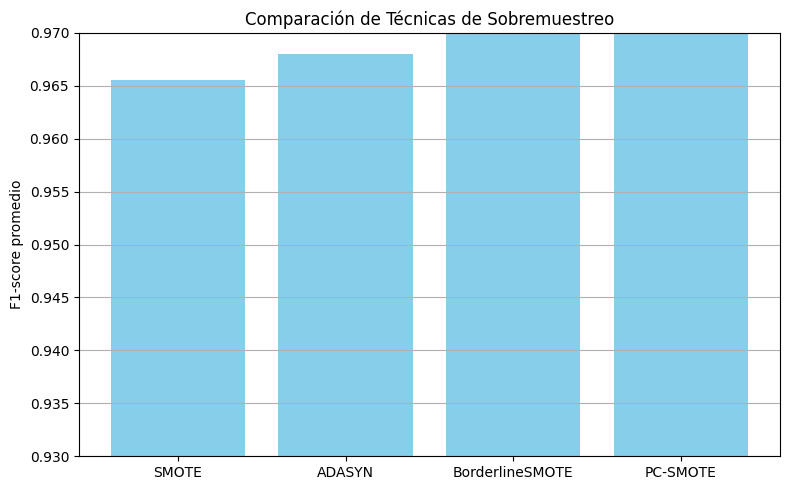

In [6]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))

from pc_smote import PCSMOTE

# Configuración general
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
import matplotlib.pyplot as plt

# Cargar dataset ecoli
ruta_ecoli = "../datasets/ecoli/ecoli.data"
df = pd.read_csv(ruta_ecoli, header=None, sep='\s+')

# Separar características y etiquetas
X = df.iloc[:, 1:8].values
y = df.iloc[:, 8].values
y_bin = np.where(y == 'cp', 1, 0)

# Función para evaluar una técnica
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score

def evaluar_sampler_completo(nombre, sampler_class, X, y_bin, n_iter=10, **kwargs):
    metrics = {
        "precision": [],
        "recall": [],
        "f1": [],
        "roc_auc": [],
        "balanced_acc": []
    }

    for seed in range(n_iter):
        sampler = sampler_class(random_state=seed, **kwargs)
        X_res, y_res = sampler.fit_resample(X, y_bin)
        model = RandomForestClassifier(random_state=seed)

        # Entrenamiento y evaluación simple (sin cross_val_score para obtener todas las métricas)
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        for train_idx, test_idx in skf.split(X_res, y_res):
            model.fit(X_res[train_idx], y_res[train_idx])
            y_pred = model.predict(X_res[test_idx])
            y_prob = model.predict_proba(X_res[test_idx])[:, 1]

            metrics["precision"].append(precision_score(y_res[test_idx], y_pred, zero_division=0))
            metrics["recall"].append(recall_score(y_res[test_idx], y_pred, zero_division=0))
            metrics["f1"].append(f1_score(y_res[test_idx], y_pred, zero_division=0))
            metrics["roc_auc"].append(roc_auc_score(y_res[test_idx], y_prob))
            metrics["balanced_acc"].append(balanced_accuracy_score(y_res[test_idx], y_pred))

    return {
        "técnica": nombre,
        "mean_precision": np.mean(metrics["precision"]),
        "mean_recall": np.mean(metrics["recall"]),
        "mean_f1": np.mean(metrics["f1"]),
        "std_f1": np.std(metrics["f1"]), 
        "mean_roc_auc": np.mean(metrics["roc_auc"]),
        "mean_bal_acc": np.mean(metrics["balanced_acc"])
    }

# Comparar técnicas
resultados = []
resultados.append(evaluar_sampler_completo("SMOTE", SMOTE, X, y_bin))
resultados.append(evaluar_sampler_completo("ADASYN", ADASYN, X, y_bin))
resultados.append(evaluar_sampler_completo("BorderlineSMOTE", BorderlineSMOTE, X, y_bin))
resultados.append(evaluar_sampler_completo("PC-SMOTE", PCSMOTE, X, y_bin, k_neighbors=5, radio_densidad=0.5))

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# Graficar resultados
plt.figure(figsize=(8, 5))
plt.bar(df_resultados["técnica"], df_resultados["mean_f1"], color='skyblue')
plt.ylabel("F1-score promedio")
plt.title("Comparación de Técnicas de Sobremuestreo")
plt.ylim(0.93, 0.97)
plt.grid(axis='y')
plt.tight_layout()
plt.show()